In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   

In [3]:
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Reproduce Figures with LR in PyTorch

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

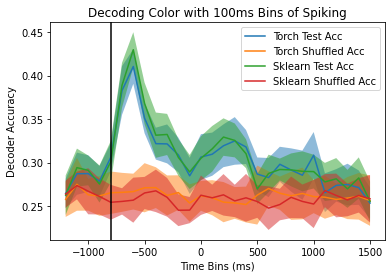

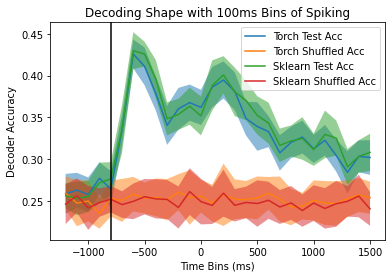

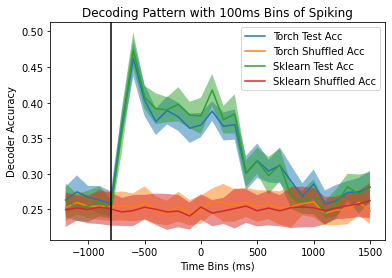

In [6]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.01)
    wrapped = ModelWrapper(MultinomialLogisticRegressor, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    _, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )

    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
    pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

    sklearn_acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    sklearn_shuffled = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Shuffled Acc",
        right_align=True
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_acc,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_shuffled,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Shuffled Acc",
        right_align=True
    )
    ax.axvline(-800, color='k')
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

### Play around with Learning Rate, Max Iter

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

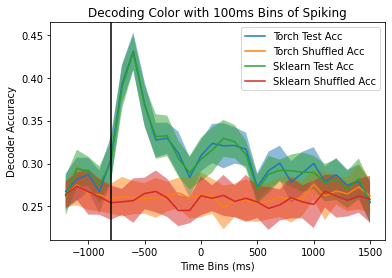

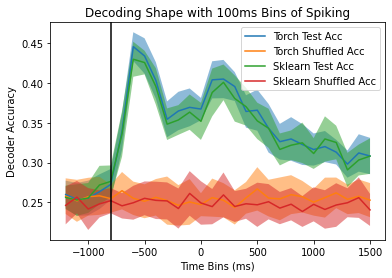

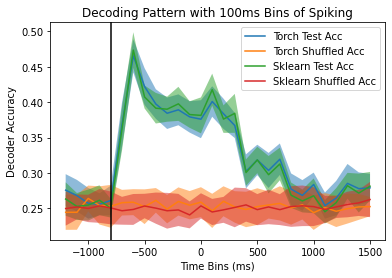

In [5]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.01, max_iter=5000)
    wrapped = ModelWrapper(MultinomialLogisticRegressor, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    _, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )

    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
    pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_lr_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

    sklearn_acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    sklearn_shuffled = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Shuffled Acc",
        right_align=True
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_acc,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_shuffled,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Shuffled Acc",
        right_align=True
    )
    ax.axvline(-800, color='k')
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

### Now try non-linear model, one hidden layer

In [5]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "n_hidden": 20, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.05, max_iter=3000)
    wrapped = ModelWrapper(MultiLayer, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    _, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )

    sklearn_acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    sklearn_shuffled = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Torch Shuffled Acc",
        right_align=True
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_acc,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        sklearn_shuffled,
        pre_interval, post_interval, 100,
        ax,
        label="Sklearn Shuffled Acc",
        right_align=True
    )
    ax.axvline(-800, color='k')
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2


KeyboardInterrupt: 

### Regen everything with Normalized Models

In [ ]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.05)
    wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    _, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )

    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
    np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
    pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))

    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        ax,
        label="Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        ax,
        label="Shuffled Acc",
        right_align=True
    )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()
    fig.savefig(f"../data/{feature_dim}_normed_model.pdf")
    fig.show()

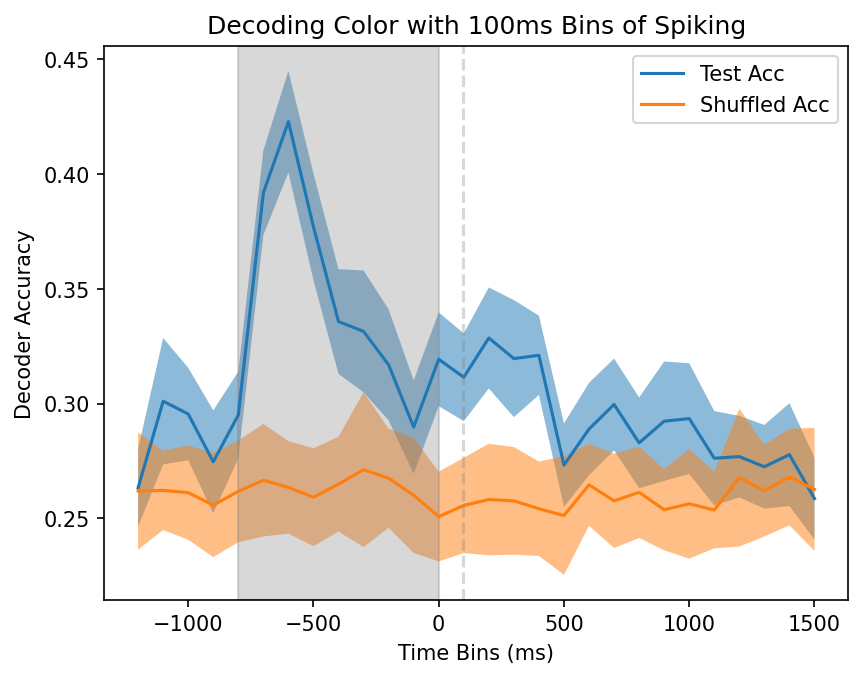

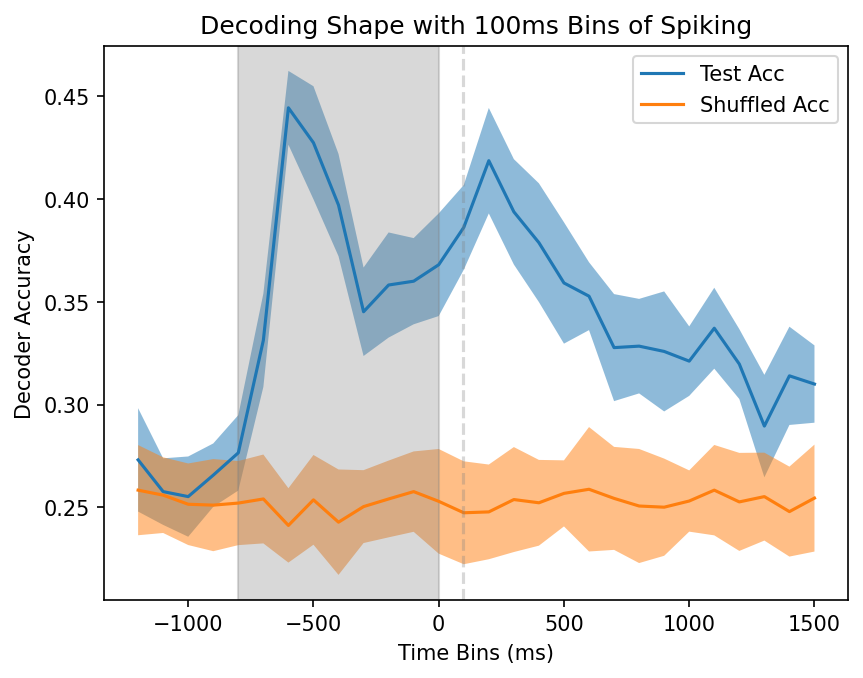

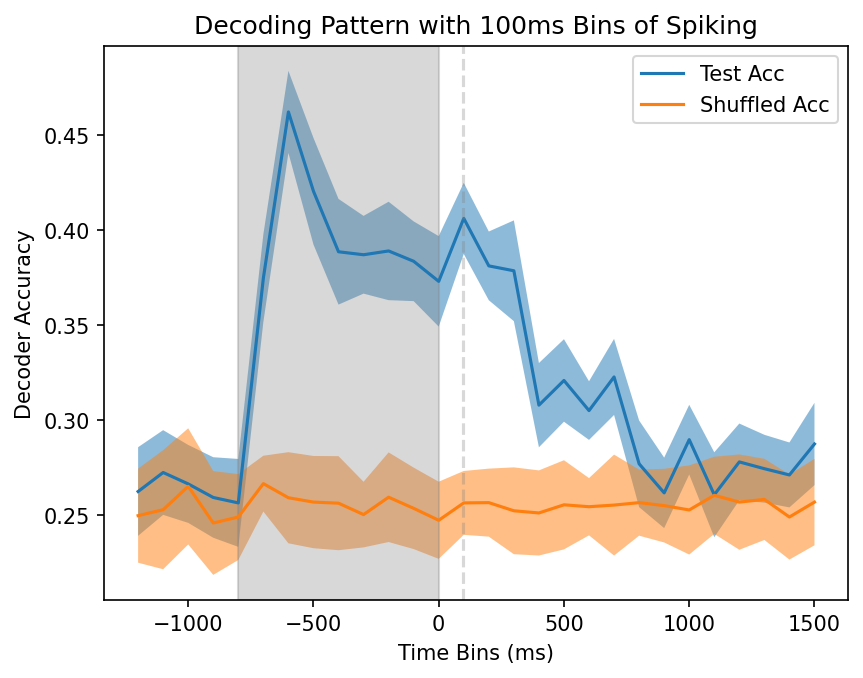

In [4]:
for feature_dim in feature_dims:
    test_acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    shuffled_acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    # generate figures
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_acc,
        pre_interval, post_interval, 100,
        ax,
        label="Test Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_acc,
        pre_interval, post_interval, 100,
        ax,
        label="Shuffled Acc",
        right_align=True
    )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Bins of Spiking")
    ax.legend()
    fig.savefig(f"../data/{feature_dim}_normed_model.pdf")
    fig.show()

### Features combined

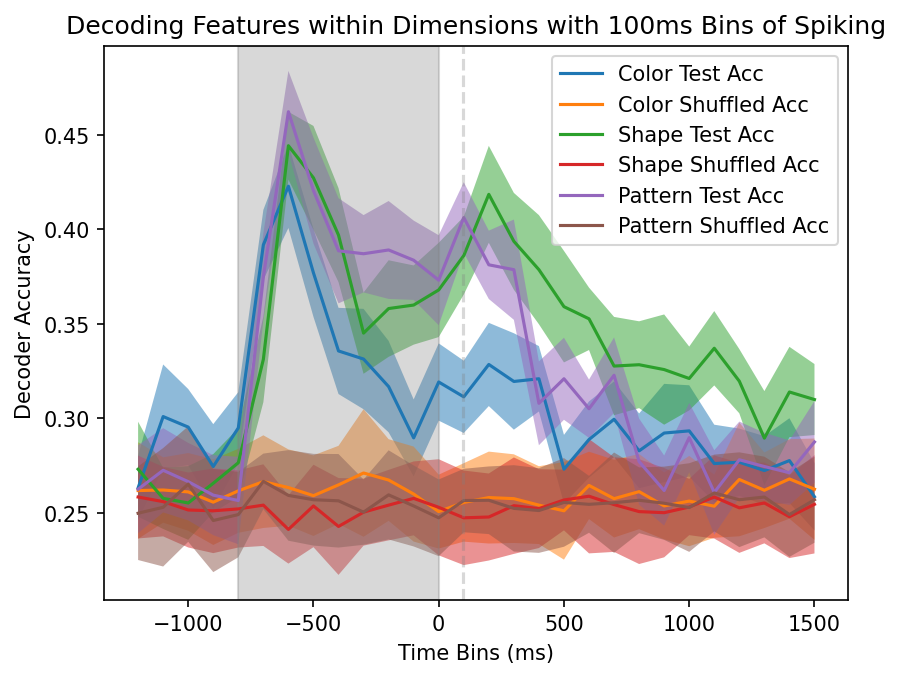

In [5]:
feature_dims = ["Color", "Shape", "Pattern"]
pre_interval = 1300
post_interval = 1500
fig, ax = plt.subplots()

for feature_dim in feature_dims:
    acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    shuffled = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_torch_normed_lr_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

    # generate figures
    visualization_utils.visualize_accuracy_across_time_bins(
        acc,
        pre_interval, post_interval, 100,
        ax,
        label=f"{feature_dim} Test Acc",
        right_align=True
    )
ax.axvspan(-800, 0, alpha=0.3, color='gray')
ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance Acc")
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Features within Dimensions with 100ms Bins of Spiking")
fig.savefig(f"../data/features_combined_no_shuffled_normed_model.pdf")
ax.legend()